In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import joblib

In [ ]:
def parse_text_file(file_path):
    descriptions = []
    criminals = []
    current_description = None
    current_criminal = None
    parsing_description = False

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove any leading/trailing whitespace

            if line.startswith("**DESCRIPTION**"):
                # Start a new description
                current_description = ""
                parsing_description = True
                current_criminal = None

            elif line.startswith("**CRIMINAL**") and parsing_description:
                # Store the criminal name associated with the current description
                if current_description is not None:
                    criminal_name = line[12:].strip()
                    descriptions.append(current_description)
                    criminals.append(criminal_name)
                    parsing_description = False

            elif parsing_description:
                # Append to the current description
                if current_description is not None:
                    current_description += line + " "  # Add the line to the current description

    return descriptions, criminals

# Example usage:
file_path = "data.txt"  # Update with your file path
crime_descriptions, criminal_names = parse_text_file(file_path)

for i in crime_descriptions:
  print(i)

print()

for i in criminal_names:
  print(i)

 In the quaint town of Willowbrook, nestled amidst lush greenery, a chilling crime unfolded one stormy night. The victim, Mr. Edward Sinclair, a renowned art collector with a penchant for controversy, was found lifeless in his opulent mansion. The scene was a tableau of horror, with shattered glass from a broken window strewn across the floor and ominous thunder echoing through the halls. Mr. Sinclair lay sprawled on the Persian rug in the study, a look of terror frozen on his face.  As the investigation unfolded, a web of intricate relationships and hidden agendas began to surface among the guests who had attended Mr. Sinclair's ill-fated soirée. Dr. Amelia Blackwood, a respected psychiatrist known for her sharp intellect and piercing gaze, was among the first to arrive, her presence suffused with an air of mystery. Mr. Henry Donovan, a shrewd businessman with a penchant for high-stakes gambling, mingled effortlessly with the elite crowd, his calculating eyes betraying little of his t

In [ ]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(criminal_names)

# Split data into train and test sets
train_descriptions, test_descriptions, train_labels, test_labels = train_test_split(
    crime_descriptions, encoded_labels, test_size=0.2, random_state=42
)

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

# Prepare dataset class
class CrimeDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer, max_length):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = str(self.descriptions[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            description,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Set up BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(criminal_names))

# Set training parameters
batch_size = 8
max_length = 500
epochs = 100
learning_rate = 2e-4

# Prepare train dataset and data loader
train_dataset = CrimeDataset(train_descriptions, train_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Prepare test dataset and data loader
test_dataset = CrimeDataset(test_descriptions, test_labels, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
loss_list = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    loss_list.append(avg_loss)
    print(f'Train Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

    # Evaluate the model on test data
    model.eval()

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f'Eval Epoch {epoch + 1}/{epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)

    print(f'Test Epoch {epoch + 1}/{epochs}')

# Save the trained model
model.save_pretrained('crime_bert_model')
tokenizer.save_pretrained('crime_bert_tokenizer')

print("Training complete. Model saved.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/100: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


Train Epoch 1/100, Loss: 3.4213


Eval Epoch 1/100: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Test Epoch 1/100


Epoch 2/100: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Train Epoch 2/100, Loss: 3.3413


Eval Epoch 2/100: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Test Epoch 2/100


Epoch 3/100: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Train Epoch 3/100, Loss: 3.2093


Eval Epoch 3/100: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Test Epoch 3/100


Epoch 4/100: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


Train Epoch 4/100, Loss: 3.1293


Eval Epoch 4/100: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Test Epoch 4/100


Epoch 5/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 5/100, Loss: 3.0501


Eval Epoch 5/100: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Test Epoch 5/100


Epoch 6/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 6/100, Loss: 3.0868


Eval Epoch 6/100: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Test Epoch 6/100


Epoch 7/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 7/100, Loss: 3.0002


Eval Epoch 7/100: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Test Epoch 7/100


Epoch 8/100: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Train Epoch 8/100, Loss: 3.0711


Eval Epoch 8/100: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Test Epoch 8/100


Epoch 9/100: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


Train Epoch 9/100, Loss: 2.9806


Eval Epoch 9/100: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Test Epoch 9/100


Epoch 10/100: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


Train Epoch 10/100, Loss: 2.9468


Eval Epoch 10/100: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Test Epoch 10/100


Epoch 11/100: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


Train Epoch 11/100, Loss: 2.9330


Eval Epoch 11/100: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Test Epoch 11/100


Epoch 12/100: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


Train Epoch 12/100, Loss: 2.8151


Eval Epoch 12/100: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Test Epoch 12/100


Epoch 13/100: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


Train Epoch 13/100, Loss: 2.5328


Eval Epoch 13/100: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Test Epoch 13/100


Epoch 14/100: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


Train Epoch 14/100, Loss: 2.2933


Eval Epoch 14/100: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Test Epoch 14/100


Epoch 15/100: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Train Epoch 15/100, Loss: 2.0548


Eval Epoch 15/100: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Test Epoch 15/100


Epoch 16/100: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


Train Epoch 16/100, Loss: 1.8445


Eval Epoch 16/100: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Test Epoch 16/100


Epoch 17/100: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


Train Epoch 17/100, Loss: 1.5653


Eval Epoch 17/100: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Test Epoch 17/100


Epoch 18/100: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


Train Epoch 18/100, Loss: 1.3695


Eval Epoch 18/100: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Test Epoch 18/100


Epoch 19/100: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


Train Epoch 19/100, Loss: 1.1620


Eval Epoch 19/100: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Test Epoch 19/100


Epoch 20/100: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


Train Epoch 20/100, Loss: 1.0506


Eval Epoch 20/100: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Test Epoch 20/100


Epoch 21/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 21/100, Loss: 0.8169


Eval Epoch 21/100: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Test Epoch 21/100


Epoch 22/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 22/100, Loss: 0.6903


Eval Epoch 22/100: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Test Epoch 22/100


Epoch 23/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 23/100, Loss: 0.4853


Eval Epoch 23/100: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Test Epoch 23/100


Epoch 24/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 24/100, Loss: 0.4146


Eval Epoch 24/100: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Test Epoch 24/100


Epoch 25/100: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train Epoch 25/100, Loss: 0.3882


Eval Epoch 25/100: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Test Epoch 25/100


Epoch 26/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 26/100, Loss: 0.2764


Eval Epoch 26/100: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Test Epoch 26/100


Epoch 27/100: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Train Epoch 27/100, Loss: 0.2482


Eval Epoch 27/100: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Test Epoch 27/100


Epoch 28/100: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Train Epoch 28/100, Loss: 0.2251


Eval Epoch 28/100: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Test Epoch 28/100


Epoch 29/100: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Train Epoch 29/100, Loss: 0.1688


Eval Epoch 29/100: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Test Epoch 29/100


Epoch 30/100: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


Train Epoch 30/100, Loss: 0.1337


Eval Epoch 30/100: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Test Epoch 30/100


Epoch 31/100: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


Train Epoch 31/100, Loss: 0.1103


Eval Epoch 31/100: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Test Epoch 31/100


Epoch 32/100: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


Train Epoch 32/100, Loss: 0.1076


Eval Epoch 32/100: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Test Epoch 32/100


Epoch 33/100: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Train Epoch 33/100, Loss: 0.0784


Eval Epoch 33/100: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Test Epoch 33/100


Epoch 34/100: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Train Epoch 34/100, Loss: 0.0694


Eval Epoch 34/100: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Test Epoch 34/100


Epoch 35/100: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Train Epoch 35/100, Loss: 0.0588


Eval Epoch 35/100: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Test Epoch 35/100


Epoch 36/100: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Train Epoch 36/100, Loss: 0.0583


Eval Epoch 36/100: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Test Epoch 36/100


Epoch 37/100: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Train Epoch 37/100, Loss: 0.0511


Eval Epoch 37/100: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Test Epoch 37/100


Epoch 38/100: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


Train Epoch 38/100, Loss: 0.0501


Eval Epoch 38/100: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Test Epoch 38/100


Epoch 39/100: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


Train Epoch 39/100, Loss: 0.0419


Eval Epoch 39/100: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Test Epoch 39/100


Epoch 40/100: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train Epoch 40/100, Loss: 0.0399


Eval Epoch 40/100: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Test Epoch 40/100


Epoch 41/100: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train Epoch 41/100, Loss: 0.0384


Eval Epoch 41/100: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Test Epoch 41/100


Epoch 42/100: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train Epoch 42/100, Loss: 0.0350


Eval Epoch 42/100: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Test Epoch 42/100


Epoch 43/100: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train Epoch 43/100, Loss: 0.0357


Eval Epoch 43/100: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Test Epoch 43/100


Epoch 44/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 44/100, Loss: 0.0338


Eval Epoch 44/100: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Test Epoch 44/100


Epoch 45/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 45/100, Loss: 0.0305


Eval Epoch 45/100: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Test Epoch 45/100


Epoch 46/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 46/100, Loss: 0.0275


Eval Epoch 46/100: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Test Epoch 46/100


Epoch 47/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 47/100, Loss: 0.0297


Eval Epoch 47/100: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Test Epoch 47/100


Epoch 48/100: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


Train Epoch 48/100, Loss: 0.0295


Eval Epoch 48/100: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Test Epoch 48/100


Epoch 49/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 49/100, Loss: 0.0255


Eval Epoch 49/100: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Test Epoch 49/100


Epoch 50/100: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Train Epoch 50/100, Loss: 0.0250


Eval Epoch 50/100: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Test Epoch 50/100


Epoch 51/100: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Train Epoch 51/100, Loss: 0.0254


Eval Epoch 51/100: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Test Epoch 51/100


Epoch 52/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 52/100, Loss: 0.0235


Eval Epoch 52/100: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Test Epoch 52/100


Epoch 53/100: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Train Epoch 53/100, Loss: 0.0227


Eval Epoch 53/100: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Test Epoch 53/100


Epoch 54/100: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Train Epoch 54/100, Loss: 0.0223


Eval Epoch 54/100: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Test Epoch 54/100


Epoch 55/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 55/100, Loss: 0.0213


Eval Epoch 55/100: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Test Epoch 55/100


Epoch 56/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 56/100, Loss: 0.0210


Eval Epoch 56/100: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Test Epoch 56/100


Epoch 57/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 57/100, Loss: 0.0205


Eval Epoch 57/100: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Test Epoch 57/100


Epoch 58/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 58/100, Loss: 0.0200


Eval Epoch 58/100: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Test Epoch 58/100


Epoch 59/100: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Train Epoch 59/100, Loss: 0.0198


Eval Epoch 59/100: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Test Epoch 59/100


Epoch 60/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 60/100, Loss: 0.0191


Eval Epoch 60/100: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Test Epoch 60/100


Epoch 61/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 61/100, Loss: 0.0187


Eval Epoch 61/100: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Test Epoch 61/100


Epoch 62/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 62/100, Loss: 0.0177


Eval Epoch 62/100: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Test Epoch 62/100


Epoch 63/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 63/100, Loss: 0.0174


Eval Epoch 63/100: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Test Epoch 63/100


Epoch 64/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 64/100, Loss: 0.0174


Eval Epoch 64/100: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Test Epoch 64/100


Epoch 65/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 65/100, Loss: 0.0157


Eval Epoch 65/100: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Test Epoch 65/100


Epoch 66/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 66/100, Loss: 0.0163


Eval Epoch 66/100: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Test Epoch 66/100


Epoch 67/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 67/100, Loss: 0.0170


Eval Epoch 67/100: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Test Epoch 67/100


Epoch 68/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 68/100, Loss: 0.0149


Eval Epoch 68/100: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Test Epoch 68/100


Epoch 69/100: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train Epoch 69/100, Loss: 0.0156


Eval Epoch 69/100: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Test Epoch 69/100


Epoch 70/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 70/100, Loss: 0.0154


Eval Epoch 70/100: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Test Epoch 70/100


Epoch 71/100: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train Epoch 71/100, Loss: 0.0146


Eval Epoch 71/100: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Test Epoch 71/100


Epoch 72/100: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train Epoch 72/100, Loss: 0.0145


Eval Epoch 72/100: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Test Epoch 72/100


Epoch 73/100: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train Epoch 73/100, Loss: 0.0130


Eval Epoch 73/100: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Test Epoch 73/100


Epoch 74/100: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train Epoch 74/100, Loss: 0.0139


Eval Epoch 74/100: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Test Epoch 74/100


Epoch 75/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 75/100, Loss: 0.0132


Eval Epoch 75/100: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Test Epoch 75/100


Epoch 76/100: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


Train Epoch 76/100, Loss: 0.0137


Eval Epoch 76/100: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Test Epoch 76/100


Epoch 77/100: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train Epoch 77/100, Loss: 0.0121


Eval Epoch 77/100: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Test Epoch 77/100


Epoch 78/100: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train Epoch 78/100, Loss: 0.0128


Eval Epoch 78/100: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Test Epoch 78/100


Epoch 79/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 79/100, Loss: 0.0127


Eval Epoch 79/100: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Test Epoch 79/100


Epoch 80/100: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train Epoch 80/100, Loss: 0.0118


Eval Epoch 80/100: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Test Epoch 80/100


Epoch 81/100: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Train Epoch 81/100, Loss: 0.0120


Eval Epoch 81/100: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Test Epoch 81/100


Epoch 82/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 82/100, Loss: 0.0116


Eval Epoch 82/100: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Test Epoch 82/100


Epoch 83/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 83/100, Loss: 0.0119


Eval Epoch 83/100: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Test Epoch 83/100


Epoch 84/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 84/100, Loss: 0.0115


Eval Epoch 84/100: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Test Epoch 84/100


Epoch 85/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 85/100, Loss: 0.0110


Eval Epoch 85/100: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Test Epoch 85/100


Epoch 86/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 86/100, Loss: 0.0108


Eval Epoch 86/100: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Test Epoch 86/100


Epoch 87/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 87/100, Loss: 0.0108


Eval Epoch 87/100: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Test Epoch 87/100


Epoch 88/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 88/100, Loss: 0.0106


Eval Epoch 88/100: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Test Epoch 88/100


Epoch 89/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 89/100, Loss: 0.0110


Eval Epoch 89/100: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Test Epoch 89/100


Epoch 90/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 90/100, Loss: 0.0099


Eval Epoch 90/100: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Test Epoch 90/100


Epoch 91/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 91/100, Loss: 0.0102


Eval Epoch 91/100: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Test Epoch 91/100


Epoch 92/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 92/100, Loss: 0.0107


Eval Epoch 92/100: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Test Epoch 92/100


Epoch 93/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 93/100, Loss: 0.0102


Eval Epoch 93/100: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Test Epoch 93/100


Epoch 94/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 94/100, Loss: 0.0095


Eval Epoch 94/100: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Test Epoch 94/100


Epoch 95/100: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Train Epoch 95/100, Loss: 0.0098


Eval Epoch 95/100: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Test Epoch 95/100


Epoch 96/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 96/100, Loss: 0.0097


Eval Epoch 96/100: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Test Epoch 96/100


Epoch 97/100: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


Train Epoch 97/100, Loss: 0.0106


Eval Epoch 97/100: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Test Epoch 97/100


Epoch 98/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 98/100, Loss: 0.0096


Eval Epoch 98/100: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Test Epoch 98/100


Epoch 99/100: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Train Epoch 99/100, Loss: 0.0089


Eval Epoch 99/100: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Test Epoch 99/100


Epoch 100/100: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


Train Epoch 100/100, Loss: 0.0086


Eval Epoch 100/100: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Test Epoch 100/100
Training complete. Model saved.


Text(0.5, 1.0, 'Epochs vs Loss Graph')

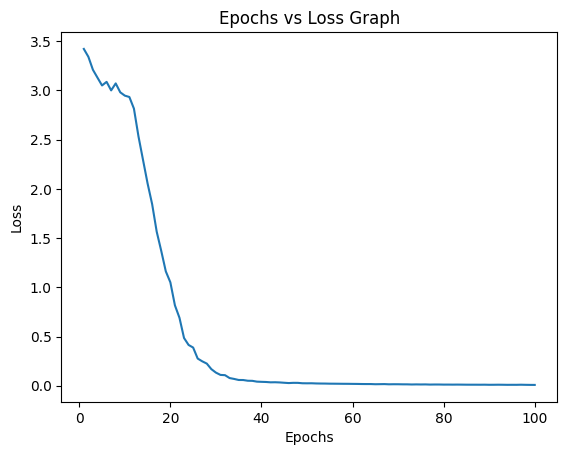

In [ ]:
import matplotlib.pyplot as plt

x = list(range(1,101))
y = loss_list

plt.plot(x, y)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss Graph")

In [ ]:
# Load saved model, tokenizer, and label encoder
model_path = 'crime_bert_model'  # Path to the saved model
tokenizer_path = 'crime_bert_tokenizer'  # Path to the saved tokenizer
label_encoder_path = 'label_encoder.pkl'  # Path to the saved label encoder

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
label_encoder = joblib.load(label_encoder_path)

# Function to predict criminal from description
def predict_criminal(description):
    encoded_input = tokenizer(description, return_tensors='pt', max_length=128, truncation=True)
    input_ids = encoded_input['input_ids']
    attention_mask = encoded_input['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
    predicted_criminal = label_encoder.inverse_transform([predicted_label])[0]

    return predicted_criminal

# Example usage
description = """In the serene town of Meadowbrook, a sinister crime unfolded one foggy evening. The victim, Mr. James Monroe, a prominent
local politician known for his charismatic charm, was discovered dead in his sprawling estate. The scene was haunting, with tendrils of mist
creeping through the corridors and casting eerie shadows on the walls. Mr. Monroe lay motionless in his study, a look of disbelief frozen on his face.
As investigators delved into the mystery, a diverse cast of characters emerged among the guests who had attended Mr. Monroe's fateful gathering.
Dr. Gregory Westwood, a renowned surgeon with a penchant for secrecy, arrived early, his demeanor guarded and inscrutable. Ms. Samantha Taylor,
a fiery journalist known for her relentless pursuit of truth, mingled with the crowd, her probing questions sparking suspicion. Mr. Daniel Thompson,
a wealthy entrepreneur with a reputation for ruthlessness, moved through the room with ease, his steely gaze betraying little of his true intentions.
Each guest harbored their own secrets and motivations, their interactions fraught with tension and hidden agendas.
As the night wore on, tempers flared and long-held grudges bubbled to the surface. Amidst heated arguments and whispered accusations, someone seized
a lethal weapon—a vintage revolver—and fired a single fatal shot, ending Mr. Monroe's life in an instant.
The murder weapon, a tarnished revolver of antique design, was discovered discarded in the garden, its barrel still warm from the fatal shot.
Yet, amidst the chaos and confusion, the identity of the killer remained elusive, shrouded in a veil of mystery.
Each guest's tangled web of lies and deceit provided investigators with a labyrinth of clues, but unraveling the truth would require navigating
the treacherous depths of deception that lurked within Meadowbrook's elite circles."""

predicted_criminal = predict_criminal(description) #Should predict Daniel Thompson

print("Predicted Criminal:", predicted_criminal)


Predicted Criminal: Mr. Daniel Thompson
